In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [3]:
def clean_figure(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis="x", rotation=45)

In [5]:
config = load_config()
od = '../snakemake/compare_external/'

## Get novelty compositions of the other things

93718


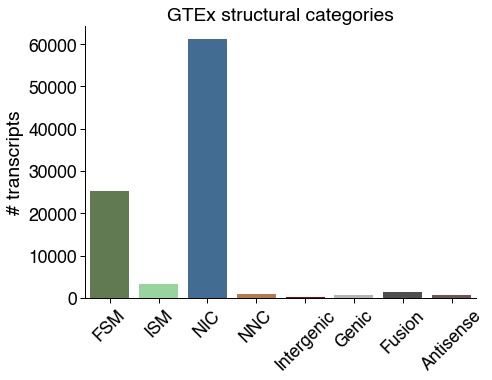

245884


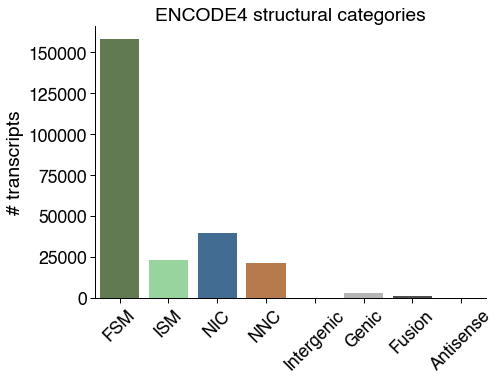

In [24]:
f_dir = '/Users/fairliereese/Documents/programming/mele_lab/projects/240903_pt/ref/compare_external/'
files = [f'{f_dir}gtex_sqanti_classification.txt',
     f'{f_dir}enc_sqanti_classification.txt']
refs = ['GTEx', 'ENCODE4']

df2 = pd.DataFrame()

for f, r in zip(files, refs):
    df = pd.read_csv(f, sep='\t')
    print(len(df))
    # break
    m = {'antisense': 'Antisense',
     'full-splice_match': 'FSM',
     'fusion': 'Fusion', 
     'genic': 'Genic', 
     'genic_intron': 'Genic', 
     'incomplete-splice_match': 'ISM',
     'novel_in_catalog': 'NIC',
     'novel_not_in_catalog': 'NNC', 
     'intergenic': 'Intergenic'}
    # print(df.structural_category.unique())
    # break
    df['structural_category'] =df['structural_category'].map(m)

    c_dict, order = get_novelty_colors()
    temp = df[['isoform', 'structural_category']].groupby('structural_category').nunique().reset_index()
    init_plot_settings(aspect='rectangle')
    ax = sns.barplot(temp, x='structural_category',
                     y='isoform',
                     palette=c_dict,
                     order=order)
    ax.set(title=f'{r} structural categories', ylabel='# transcripts', xlabel='')
    clean_figure(ax)
    plt.show()
    
    temp['source'] = r
    df2 = pd.concat([temp, df2], axis=0)

In [27]:
df2.to_csv('241113_enc_gtex_sqanti_v47.tsv', sep='\t')

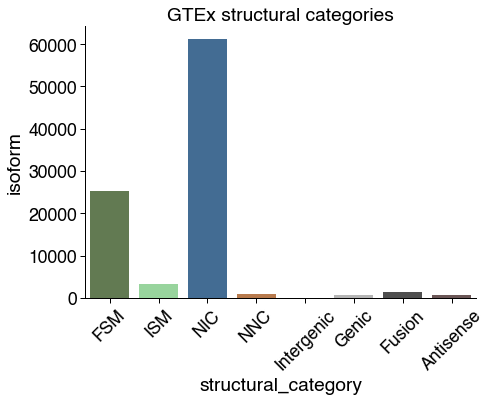

In [18]:
m = {'antisense': 'Antisense',
     'full-splice_match': 'FSM',
     'fusion': 'Fusion', 
     'genic': 'Genic', 
     'genic_intron': 'Genic', 
     'incomplete-splice_match': 'ISM',
     'novel_in_catalog': 'NIC',
     'novel_not_in_catalog': 'NNC'}
df['structural_category'] =df['structural_category'].map(m)

c_dict, order = get_novelty_colors()
temp = df[['isoform', 'structural_category']].groupby('structural_category').nunique().reset_index()
init_plot_settings(aspect='rectangle')
ax = sns.barplot(temp, x='structural_category',
                 y='isoform',
                 palette=c_dict,
                 order=order)
ax.set(title=f'{r} structural categories')
clean_figure(ax)